In [ ]:
!pip install deepdow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.9/52.9 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 74.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 KB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import cvxpy as cp
import seaborn
from deepdow.benchmarks import Benchmark, OneOverN, Random
from deepdow.callbacks import EarlyStoppingCallback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.data.synthetic import sin_single
from deepdow.experiments import Run
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap

torch.manual_seed(4)
np.random.seed(5)

In [ ]:
assets = pd.read_csv('/content/drive/MyDrive/uchicago trading/Training Data_Case 3.csv', index_col=0)
assets

,A,B,C,D,E,F,G,H,I,J
1,119.96,198.25,76.54,32.08,53.20,19.47,40.63,43.47,19.76,113.91
2,120.32,201.42,76.73,31.86,53.88,19.23,40.47,45.16,19.88,112.98
3,119.60,200.23,77.60,31.56,55.11,18.93,39.84,46.03,20.29,114.24
4,121.76,199.61,79.48,31.62,55.80,19.15,40.13,46.89,20.01,114.27
5,120.10,199.64,81.49,31.89,55.02,19.16,39.94,47.59,20.12,113.87
...,...,...,...,...,...,...,...,...,...,...
2516,317.31,1385.04,199.14,273.02,52.11,89.45,151.54,390.13,88.25,35.99
2517,317.20,1358.01,202.59,277.45,52.73,90.93,152.39,394.03,87.56,35.89
2518,312.31,1315.00,198.29,281.23,52.71,92.28,153.92,375.70,89.54,36.13
2519,312.45,1319.59,200.78,282.77,52.26,93.49,155.26,368.33,91.36,35.15


<Axes: >

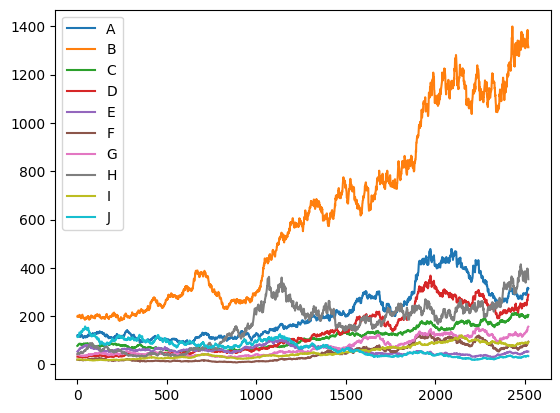

In [ ]:
assets.plot()

In [ ]:
corr_df = assets.corr(method='pearson')
#reset symbol as index (rather than 0-X)
corr_df.head().reset_index()
#del corr_df.index.name
corr_df

,A,B,C,D,E,F,G,H,I,J
A,1.000000,0.907763,0.876312,0.977546,-0.585680,0.976689,0.947130,0.588398,0.931284,-0.796871
B,0.907763,1.000000,0.952322,0.949021,-0.563379,0.902734,0.934653,0.756198,0.960922,-0.863604
C,0.876312,0.952322,1.000000,0.913316,-0.602664,0.896976,0.937151,0.680581,0.907120,-0.822143
D,0.977546,0.949021,0.913316,1.000000,-0.606136,0.979219,0.970006,0.656929,0.952789,-0.851680
E,-0.585680,-0.563379,-0.602664,-0.606136,1.000000,-0.627725,-0.640013,-0.043075,-0.656586,0.772634
F,0.976689,0.902734,0.896976,0.979219,-0.627725,1.000000,0.966342,0.564128,0.920264,-0.810844
G,0.947130,0.934653,0.937151,0.970006,-0.640013,0.966342,1.000000,0.614272,0.924578,-0.839205
H,0.588398,0.756198,0.680581,0.656929,-0.043075,0.564128,0.614272,1.000000,0.656634,-0.550657
I,0.931284,0.960922,0.907120,0.952789,-0.656586,0.920264,0.924578,0.656634,1.000000,-0.887359
J,-0.796871,-0.863604,-0.822143,-0.851680,0.772634,-0.810844,-0.839205,-0.550657,-0.887359,1.000000


<Figure size 640x480 with 0 Axes>

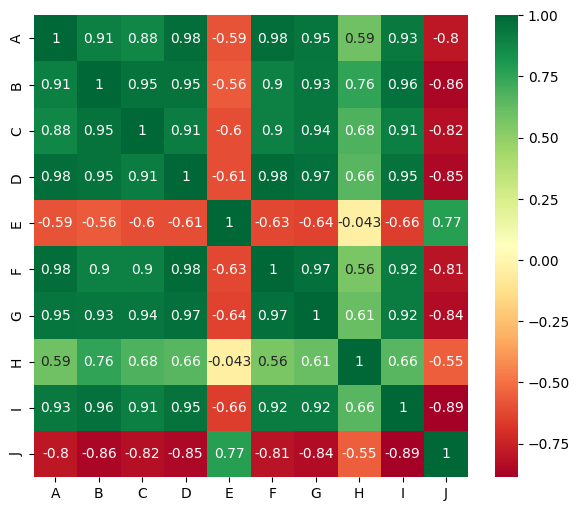

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(7, 6))
seaborn.heatmap(corr_df, annot=True, cmap='RdYlGn')
plt.figure()

# Different Types of Optimizers and Allocating Methods
What we want is a high sharpe ratio.

## Mean-Variance Optimization

In [ ]:
data = assets
# Calculate expected returns and covariance matrix
returns = data.pct_change().mean() * 252
cov_matrix = data.pct_change().cov() * 252

In [ ]:
def optimize_portfolio(returns, cov_matrix):
    """
    Optimize portfolio allocation using mean-variance optimization
    """
    n_assets = len(returns)
    args = (returns, cov_matrix)

    def portfolio_variance(weights, returns, cov_matrix):
        """
        Calculate portfolio variance given weights
        """
        return np.dot(weights.T, np.dot(cov_matrix, weights))

    def portfolio_return(weights, returns, cov_matrix):
        """
        Calculate portfolio return given weights
        """
        return np.dot(weights.T, returns)

    # Constraints
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds
    bounds = tuple((0, 1) for _ in range(n_assets))

    # Initial guess (equal allocation)
    init_guess = np.ones(n_assets) / n_assets

    # Optimization
    result = minimize(portfolio_variance, init_guess, args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)

    if not result.success:
        raise ValueError("Optimization failed: {}".format(result.message))

    return result.x

In [ ]:
# Get optimal portfolio weights
weights = optimize_portfolio(returns, cov_matrix)

# Print portfolio allocation
print("Portfolio allocation:")
for i, weight in enumerate(weights):
    print("Asset {}: {:.2f}%".format(i+1, weight*100))

Portfolio allocation:
Asset 1: 3.86%
Asset 2: 15.35%
Asset 3: 28.52%
Asset 4: 8.01%
Asset 5: 12.72%
Asset 6: 0.00%
Asset 7: 0.41%
Asset 8: 7.64%
Asset 9: 21.21%
Asset 10: 2.28%


## Minimum Variance Optimization
This implementation solves the quadratic optimization problem. The objective is to minimize the portfolio risk, subject to the constraint that the weights sum to one and are non-negative.

The resulting weights represent the minimum variance portfolio allocation, which should have the lowest possible portfolio volatility or risk, subject to the constraints.

In [ ]:
# Calculate expected returns and covariance matrix
returns = data.pct_change().mean()
cov_matrix = data.pct_change().cov()

# Define optimization problem
n_assets = len(returns)
weights = cp.Variable(n_assets)
risk = cp.quad_form(weights, cov_matrix)
constraints = [cp.sum(weights) == 1, weights >= 0]
objective = cp.Minimize(risk)
problem = cp.Problem(objective, constraints)

# Solve optimization problem
problem.solve()

# Print results
print("Minimum variance portfolio allocation:")
for i, weight in enumerate(weights.value):
    print("Asset {}: {:.2f}%".format(i+1, weight*100))

Minimum variance portfolio allocation:
Asset 1: 3.49%
Asset 2: 15.29%
Asset 3: 28.46%
Asset 4: 8.68%
Asset 5: 12.49%
Asset 6: 0.00%
Asset 7: 0.04%
Asset 8: 7.75%
Asset 9: 21.41%
Asset 10: 2.40%


## Risk Parity Allocation
In this implementation, we calculate the asset weights based on the inverse of the volatility of each asset, rather than their expected returns. The idea is to weight the assets in proportion to their contribution to the overall portfolio risk, rather than their expected returns.

We then normalize the weights so that they sum to one, which ensures that the portfolio is fully invested.

The resulting weights represent the risk parity portfolio allocation, which should have a more balanced risk profile and be less sensitive to any one asset class or market factor.

In [ ]:
# Calculate asset weights based on inverse volatility
weights = 1 / np.sqrt(data.pct_change().var())

# Normalize weights to sum to 1
weights /= np.sum(weights)

# Print results
print("Risk parity portfolio allocation:")
for i, weight in enumerate(weights):
    print("Asset {}: {:.2f}%".format(i+1, weight*100))

Risk parity portfolio allocation:
Asset 1: 10.26%
Asset 2: 13.03%
Asset 3: 14.09%
Asset 4: 9.66%
Asset 5: 9.92%
Asset 6: 6.97%
Asset 7: 8.93%
Asset 8: 6.24%
Asset 9: 12.95%
Asset 10: 7.95%


## Tactical Asset Allocation
We define the long and short moving averages and calculate them using the rolling() method of the DataFrame object.

Next, we create signals based on the moving average crossover. We use a DataFrame object called signals to store the signals, where each cell can take one of three values: 1 (long signal), -1 (short signal), or 0 (no signal).

We then use the signals to calculate the asset allocation weights. We shift the signals by one day so that we use yesterday's signals to make today's allocation. We start with zero weights on the first day, and normalize the weights so that they sum to 1 for each day.

Finally, we calculate the portfolio returns by multiplying the asset returns by the weights and summing across assets. We calculate the cumulative returns by taking the cumulative product of the portfolio returns.

This implementation uses Moving Average Crossover as an example strategy.

0.41024372664996867


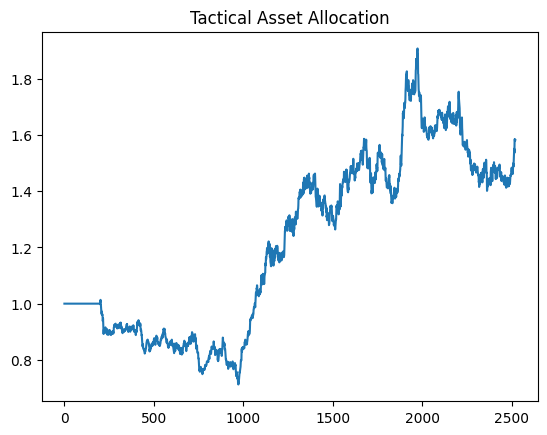

In [ ]:
# Define the long and short moving averages
long_ma = 200
short_ma = 50

# Calculate the moving averages
ma_long = data.rolling(long_ma).mean()
ma_short = data.rolling(short_ma).mean()

# Create signals based on the moving average crossover
signals = pd.DataFrame(0, index=data.index, columns=data.columns)
signals[ma_short > ma_long] = 1
signals[ma_short <= ma_long] = -1

# Calculate the asset allocation weights
weights = signals.shift(1)  # Use yesterday's signals to make today's allocation
weights.iloc[0, :] = 0  # Start with zero weights
weights = weights.div(np.abs(weights).sum(axis=1), axis=0)  # Normalize to sum to 1

# Calculate the portfolio returns
returns = data.pct_change()
portfolio_returns = (weights * returns).sum(axis=1)

# Calculate the cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot the results
cumulative_returns.plot( title='Tactical Asset Allocation')
sharpe_ratio = np.sqrt(252) * portfolio_returns.mean() / portfolio_returns.std()
print(sharpe_ratio)

## TAA using relative strength

Sharpe ratio: 0.39
Annual return: 146.61
Max drawdown: -1.00


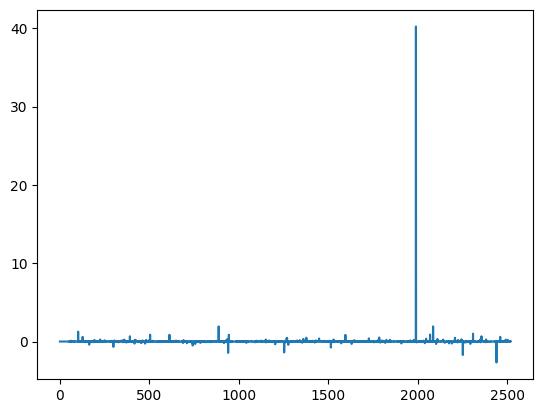

In [ ]:
# Define lookback periods
lookback_short = 20
lookback_long = 50

# Initialize portfolio weights
weights = pd.DataFrame(columns=assets.columns, index=assets.index)

# Iterate over each day
for i in range(lookback_long, len(assets)):

    # Calculate returns over lookback periods
    returns_short = assets.iloc[i-lookback_short:i].pct_change().dropna()
    returns_long = assets.iloc[i-lookback_long:i].pct_change().dropna()

    # Calculate relative strength
    relative_strength = returns_short.mean() / returns_long.mean()

    # Calculate weights based on relative strength
    weights.iloc[i] = relative_strength / relative_strength.sum()

# Add a small constant to avoid division by zero
weights_sum = weights.sum(axis=1) + 1e-6

# Normalize weights
weights = weights.div(weights_sum, axis=0)

# Calculate daily portfolio returns
portfolio_returns = (weights.shift(1) * assets.pct_change()).sum(axis=1)
plt.plot(portfolio_returns)

# Calculate performance metrics
sharpe_ratio = np.sqrt(252) * portfolio_returns.mean() / portfolio_returns.std()
annual_return = (1 + portfolio_returns.mean())**252 - 1
max_drawdown = (portfolio_returns / (1 + portfolio_returns)).cumprod().cummax() - 1

print(f'Sharpe ratio: {sharpe_ratio:.2f}')
print(f'Annual return: {annual_return:.2f}')
print(f'Max drawdown: {max_drawdown.min():.2f}')


## Momentum-based TAA Strategy

Sharpe ratio: 0.19
Annual return: 31.88
Max drawdown: -1.00


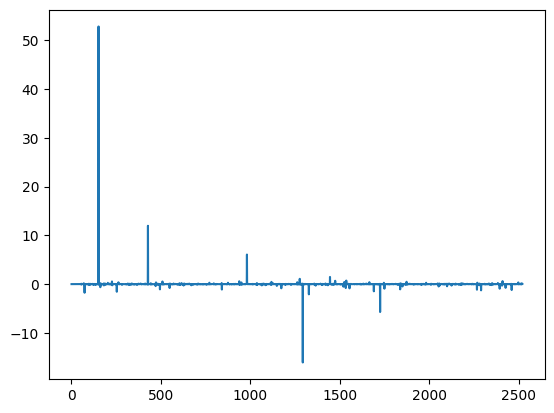

In [ ]:
# Define lookback periods
lookback_short = 20
lookback_long = 50

# Initialize portfolio weights
weights = pd.DataFrame(columns=assets.columns, index=assets.index)

# Iterate over each day
for i in range(lookback_long, len(assets)):

    # Calculate returns over lookback periods
    returns_short = assets.iloc[i-lookback_short:i].pct_change().dropna()
    returns_long = assets.iloc[i-lookback_long:i].pct_change().dropna()

    # Calculate momentum
    momentum = returns_short.sum() / abs(returns_short).sum() - returns_long.sum() / abs(returns_long).sum()

    # Calculate weights based on momentum
    weights.iloc[i] = momentum / momentum.sum()

# Add a small constant to avoid division by zero
weights_sum = weights.sum(axis=1) + 1e-6

# Normalize weights
weights = weights.div(weights_sum, axis=0)

# Calculate daily portfolio returns
portfolio_returns = (weights.shift(1) * assets.pct_change()).sum(axis=1)
plt.plot(portfolio_returns)

# Calculate performance metrics
sharpe_ratio = np.sqrt(252) * portfolio_returns.mean() / portfolio_returns.std()
annual_return = (1 + portfolio_returns.mean())**252 - 1
max_drawdown = (portfolio_returns / (1 + portfolio_returns)).cumprod().cummax() - 1

print(f'Sharpe ratio: {sharpe_ratio:.2f}')
print(f'Annual return: {annual_return:.2f}')
print(f'Max drawdown: {max_drawdown.min():.2f}')

## Neural Network

In [ ]:
# Load data
data = assets

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Train the neural network
net = Net()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

for epoch in range(1000):
    inputs = torch.tensor(data[:-1].values, dtype=torch.float32)
    targets = torch.tensor(data[1:].values, dtype=torch.float32)

    print(net(inputs))

    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    print('Epoch: %d, Loss: %.6f' % (epoch+1, loss.item()))

# Use the trained neural network to make predictions
with torch.no_grad():
    inputs = torch.tensor(data.values, dtype=torch.float32)
    outputs = net(inputs)
    predictions = outputs.numpy()

# Calculate daily returns and annualized volatility
returns = np.diff(data.values, axis=0) / data.values[:-1]
volatility = np.std(returns, axis=0) * np.sqrt(252)


# Use the predictions to optimize portfolio weights
weights = np.zeros(10)
for i in range(10):
    weights[i] = predictions[-1, i] / volatility[i]

weights = weights / np.sum(weights)

# Print the optimized weights and Sharpe Ratio
print('Optimized Weights:', weights)
print('Sharpe Ratio:', np.dot(returns[-1], weights) / np.std(returns[-1]) * np.sqrt(252))

Streaming output truncated to the last 5000 lines.
tensor([[ 3.3893, -1.1421, -0.4926,  ..., -4.1014, -1.7597,  0.7981],
        [ 3.3893, -1.1421, -0.4926,  ..., -4.1014, -1.7597,  0.7981],
        [ 3.3893, -1.1421, -0.4926,  ..., -4.1014, -1.7597,  0.7981],
        ...,
        [ 3.3893, -1.1421, -0.4926,  ..., -4.1014, -1.7597,  0.7981],
        [ 3.3893, -1.1421, -0.4926,  ..., -4.1014, -1.7597,  0.7981],
        [ 3.3893, -1.1421, -0.4926,  ..., -4.1014, -1.7597,  0.7981]],
       grad_fn=<AddmmBackward0>)
Epoch: 448, Loss: 67376.562500
tensor([[ 3.4305, -1.0182, -0.4707,  ..., -4.0670, -1.7491,  0.8117],
        [ 3.4305, -1.0182, -0.4707,  ..., -4.0670, -1.7491,  0.8117],
        [ 3.4305, -1.0182, -0.4707,  ..., -4.0670, -1.7491,  0.8117],
        ...,
        [ 3.4305, -1.0182, -0.4707,  ..., -4.0670, -1.7491,  0.8117],
        [ 3.4305, -1.0182, -0.4707,  ..., -4.0670, -1.7491,  0.8117],
        [ 3.4305, -1.0182, -0.4707,  ..., -4.0670, -1.7491,  0.8117]],
       grad_fn=<A

# Using DeepDow

In progress

In [ ]:
lookback, gap, horizon = 40, 2, 20
n_samples = len(assets) - lookback - horizon - gap + 1

In [ ]:
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:1966
Test range: 2027:2458
